In [35]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import dataFrameTools
import processGen
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
# from cloudpickle import CloudPickler
import tensorflow_probability as tfp
import random
from random import randrange
import checkdf
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA


In [2]:
def loadData2():
    df=dataFrameTools.normalizeDF(0).astype('float32')
    images=[]
    for i in df.index.values:
        filePath=Path("../Processed Images/Grayscale/(" + str(i) + ").png")
        image=cv2.imread(str(filePath),0)
        images.append(image)
    images=np.array(images)
    #scale image values
    images=images/255.0
    split = train_test_split(df, images, test_size=0.3, random_state=42)
    dtrain, dtv, itrain, itv = split
    dtest, dval, itest, ival = train_test_split(dtv, itv, test_size=0.5, random_state=42)
    itrain=tf.expand_dims(itrain, -1)
    ival=tf.expand_dims(ival, -1)
    itest=tf.expand_dims(itest, -1)
    imdims=np.shape(itrain[1])
    ddims=len(dtrain.columns)
    return dtrain,dval,dtest,itrain,ival,itest,imdims,ddims

def custom_sigmoid_cross_entropy_loss_with_logits(x_true, x_recons_logits):
    raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x_true, logits=x_recons_logits)
    if len(np.shape(x_true))==4:
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])
    else:
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1])
    return tf.math.reduce_mean(neg_log_likelihood)

In [3]:
class dVAE:
    def __init__(self, datadims, latent_dim, kl_weight, learning_rate):
        self.dim_x = datadims
        self.latent_dim = latent_dim
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
    def encoder(self, return_mean = 0, trainable=True):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(self.latent_dim), scale=1.), 
                                reinterpreted_batch_ndims=1)
        
        model=[layers.InputLayer(input_shape=self.dim_x)]
        
        model.append(layers.Dense(200, name="e0"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))

        model.append(layers.Dense(200, name="e1"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="e2"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="e3"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="e4"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(tfp.layers.IndependentNormal.params_size(self.latent_dim), name="e5"))
        if return_mean:
                model.append(tfp.layers.IndependentNormal(self.latent_dim, convert_to_tensor_fn=tfp.distributions.Distribution.mean, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=self.kl_weight), name="e6"))
        else:
                model.append(tfp.layers.IndependentNormal(self.latent_dim, convert_to_tensor_fn=tfp.distributions.Distribution.sample, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=self.kl_weight), name="e6"))
        return keras.Sequential(model, name='encoder')
    
    
    def decoder(self):
        decoder=keras.Sequential()
        model=[layers.InputLayer(input_shape=(self.latent_dim,))]

        model.append(layers.Dense(200, name="d0"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))

        model.append(layers.Dense(200, name="d1"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="d2"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="d3"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="d4"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        
        model.append(layers.Dense(self.dim_x, name="d5"))

        return keras.Sequential(model, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = keras.Input(shape=self.dim_x)
        encoder = self.encoder()
        decoder = self.decoder()
#         encoder.summary()
#         decoder.summary()
        z = encoder(x_input)
        output=decoder(z)
        negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
        
        # compile VAE model
        model = keras.Model(inputs=x_input, outputs=output)
        model.compile(loss=custom_sigmoid_cross_entropy_loss_with_logits, optimizer=keras.optimizers.Adam(self.learning_rate))
        return model
    
    def build_vae_keras_model_mean(self):
        x_input = keras.Input(shape=self.dim_x)
        encoder = self.encoder(return_mean=1)
        decoder = self.decoder()
        z = encoder(x_input)
        output=decoder(z)
        negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
        
        # compile VAE model
        model = keras.Model(inputs=x_input, outputs=output)
        model.compile(loss=custom_sigmoid_cross_entropy_loss_with_logits, optimizer=keras.optimizers.Adam(self.learning_rate))
        return model

In [4]:
def my_loadData2(bikestyle = None):
    df=dataFrameTools.normalizeDF(0).astype('float32')
    if bikestyle:
        red = pd.read_csv("../data/BIKED_reduced.csv", index_col=0)
        if isinstance(bikestyle, list):
            indices = red[red['BIKESTYLE'].isin(bikestyle)].index
        else:
            indices = red[red['BIKESTYLE'] == bikestyle].index
        
        df = df.loc[indices]

    split = train_test_split(df, test_size=0.3, random_state=42)
    dtrain, dtv, = split
    dtest, dval = train_test_split(dtv, test_size=0.5, random_state=42)
    ddims=len(dtrain.columns)
    return dtrain,dval,dtest,ddims

In [5]:
dtrain, dval, dtest, itrain, ival, itest, imdims, ddims = loadData2()
dataVAE_model =dVAE(ddims, 128, 0.1, 1e-3)
dataVAE_mean = dataVAE_model.build_vae_keras_model_mean()
dataVAE_mean.load_weights('../model weights/dataVAE.h5')
encoder_mean =  dataVAE_mean.get_layer('encoder')

Loaded Imputed Dataframe in  1.5092058181762695 seconds


In [6]:
dfn = dataFrameTools.normalizeDF(0).astype('float32')

bike_ids = [2051, 3, 4, 516, 9, 1034, 3086, 17, 3090, 3092, 3605, 4632, 2040, 28, 3101, 3617, 4644, 4134, 2601, 4658, 4149, 4150, 1079, 1593, 1082, 1084, 61, 64, 4672, 4674, 4677, 1093, 2119, 72, 4679, 3654, 75, 76, 4171, 80, 1106, 3155, 4692, 4182, 598, 4697, 602, 91, 2653, 4089, 608, 3681, 1634, 1635, 1642, 4715, 109, 4719, 4720, 4722, 2675, 3701, 3703, 1149, 4738, 1666, 3717, 3721, 4234, 650, 140, 4240, 2704, 3730, 4756, 3223, 1175, 4249, 3227, 2716, 4766, 3230, 4256, 3742, 4258, 4779, 4781, 4782, 2737, 4277, 4278, 3765, 1210, 4795, 3261, 2750, 2753, 195, 4293, 4294, 2758, 1737, 1228, 206, 1231, 1744, 1746, 1240, 3804, 1249, 1251, 1766, 3303, 2798, 1775, 3314, 3317, 1784, 4346, 4347, 4350, 4352, 1280, 3854, 3857, 2836, 1816, 3363, 810, 1837, 816, 2865, 818, 3379, 2868, 1332, 1842, 4407, 2877, 1348, 1349, 3910, 3911, 3919, 849, 4434, 344, 4441, 1370, 2910, 1886, 4448, 2915, 4453, 1897, 4458, 4460, 3950, 2421, 4475, 4483, 4486, 2441, 2442, 4494, 915, 4500, 4501, 4507, 4510, 4520, 4010, 2475, 1451, 4525, 433, 3507, 2485, 2997, 4535, 1461, 4031, 1985, 3523, 1476, 4041, 3021, 4046, 4563, 3030, 983, 4055, 4569, 4571, 3037, 990, 3549, 4061, 3553, 4578, 4581, 4069, 999, 4588, 3566, 4591, 3571, 1528, 3065, 3066]
edited_df = dfn.loc[bike_ids]


Loaded Imputed Dataframe in  1.453078269958496 seconds


In [30]:
cols = ['BB diameter', 'BB length', 'BB textfield', 'BELTorCHAIN', 'BSD front',
       'BSD rear', 'CHAINSTAYbrdgCheck', 'CHAINSTAYbrdgdia1',
       'CHAINSTAYbrdgshift', 'CS textfield', 'Chain stay position on BB',
       'DT Length', 'Display AEROBARS', 'Display RACK', 'Down tube diameter',
       'Dropout spacing', 'Dropout spacing style', 'ERD front', 'ERD rear',
       'Fork type', 'Front Fender include', 'Handlebar style', 'Head angle',
       'Head tube diameter', 'Head tube length textfield',
       'Head tube lower extension2', 'Head tube type',
       'Head tube upper extension2', 'Number of chainrings', 'Number of cogs',
       'Rear Fender include', 'SBLADEW front', 'SBLADEW rear',
       'SEATSTAYbrdgCheck', 'SEATSTAYbrdgdia1', 'SEATSTAYbrdgshift',
       'SPOKES composite front', 'SSTopZOFFSET', 'Saddle height',
       'Saddle length', 'Seat angle', 'Seat stay junction0',
       'Seat tube diameter', 'Seat tube extension2', 'Seat tube length',
       'Seatpost LENGTH', 'Stack', 'Stem kind', 'Top tube type',
       'Wall thickness Bottom Bracket', 'Wall thickness Chain stay',
       'Wall thickness Down tube', 'Wall thickness Head tube',
       'Wall thickness Seat stay', 'Wall thickness Seat tube',
       'Wall thickness Top tube', 'Wheel cut', 'Wheel width front',
       'Wheel width rear', 'bottle DOWNTUBE0 show', 'bottle SEATTUBE0 show',
       'csd', 'dtd', 'ssd', 'ttd']

In [31]:
intersection = set(dfn.columns).intersection(cols)
print(intersection)


{'SPOKES composite front', 'BB textfield', 'Wall thickness Chain stay', 'CS textfield', 'BB diameter', 'Head tube diameter', 'Wheel width rear', 'CHAINSTAYbrdgdia1', 'Saddle length', 'Seat angle', 'Head tube length textfield', 'BB length', 'SBLADEW rear', 'Wheel width front', 'Wheel cut', 'Wall thickness Seat tube', 'Number of cogs', 'Seat tube extension2', 'Saddle height', 'Seat tube length', 'Wall thickness Seat stay', 'Head tube lower extension2', 'SEATSTAYbrdgshift', 'Stack', 'Seat stay junction0', 'CHAINSTAYbrdgCheck', 'CHAINSTAYbrdgshift', 'Dropout spacing', 'Front Fender include', 'Seat tube diameter', 'Display AEROBARS', 'SBLADEW front', 'SSTopZOFFSET', 'Seatpost LENGTH', 'Down tube diameter', 'Rear Fender include', 'SEATSTAYbrdgdia1', 'Number of chainrings', 'Display RACK', 'Head angle', 'SEATSTAYbrdgCheck', 'Chain stay position on BB', 'Head tube upper extension2'}


SPOKES composite front


C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2997998117102875' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.29959961149964603' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2993994112890046' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\

32/32 [==============================] - 0s 3ms/step


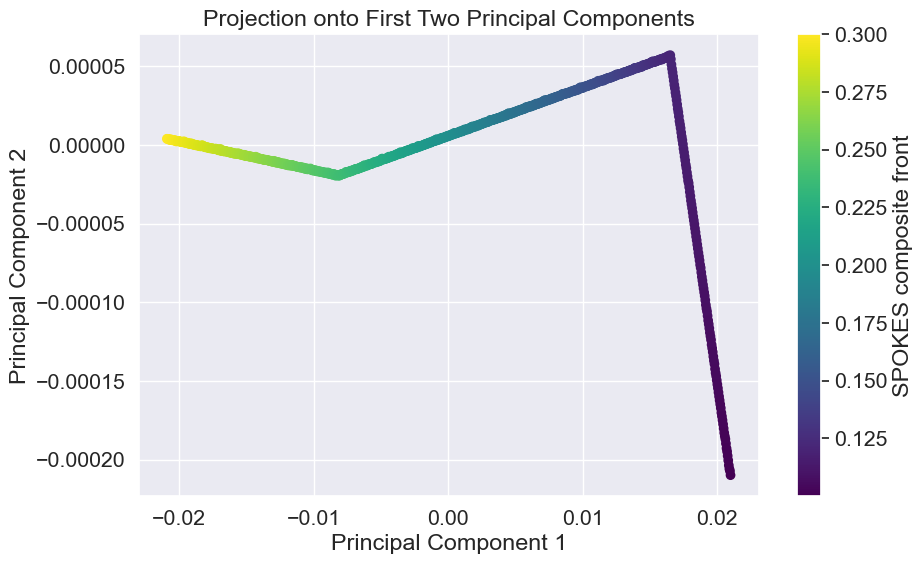

Top 10 features contributing to the first principal component:
Index([25, 78, 113, 46, 91, 1, 16, 79, 124, 95], dtype='int64')
BB textfield


C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.686018557519884' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6859626793288611' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6859068011378383' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\Ap

32/32 [==============================] - 0s 2ms/step


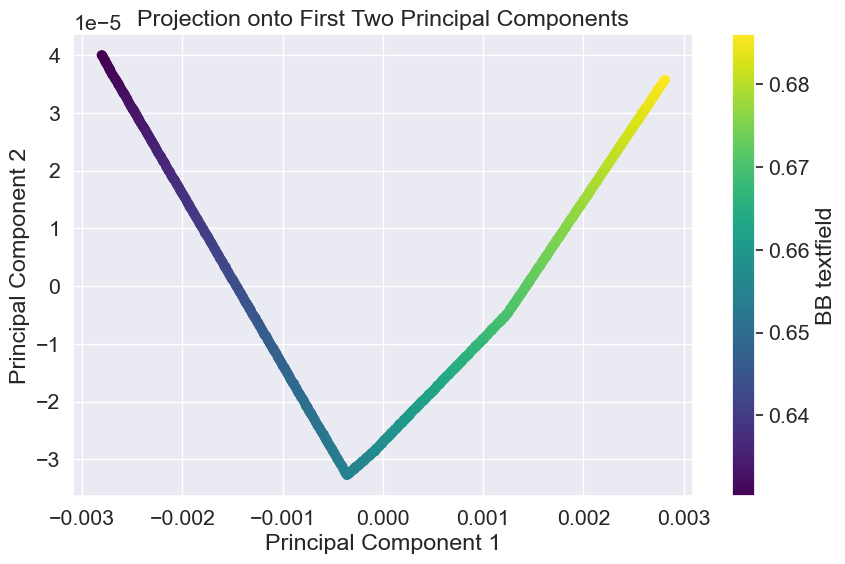

Top 10 features contributing to the first principal component:
Index([1, 113, 124, 46, 79, 25, 91, 16, 103, 10], dtype='int64')
Wall thickness Chain stay
32/32 [==============================] - 0s 2ms/step


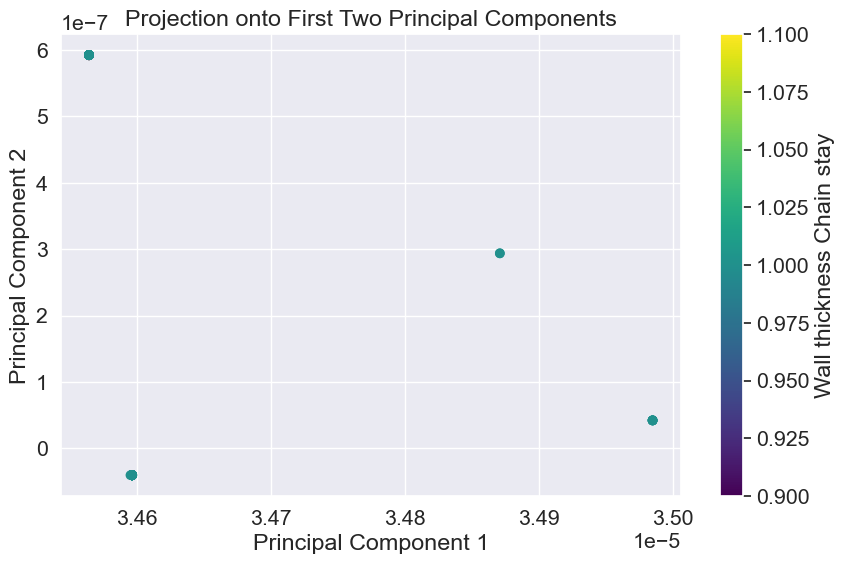

Top 10 features contributing to the first principal component:
Index([91, 16, 25, 124, 113, 79, 78, 85, 37, 96], dtype='int64')
CS textfield


C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.24841039479375482' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.24832078517676592' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.24823117555977703' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabi

32/32 [==============================] - 0s 2ms/step


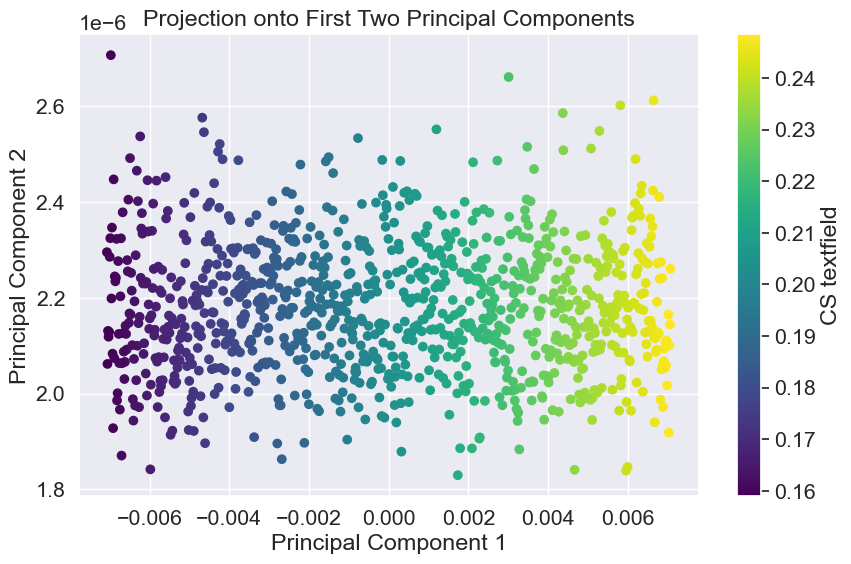

Top 10 features contributing to the first principal component:
Index([78, 16, 91, 113, 25, 124, 79, 46, 73, 1], dtype='int64')
BB diameter


C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.66637750845533' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6660883303757783' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6657991522962267' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\App

32/32 [==============================] - 0s 2ms/step


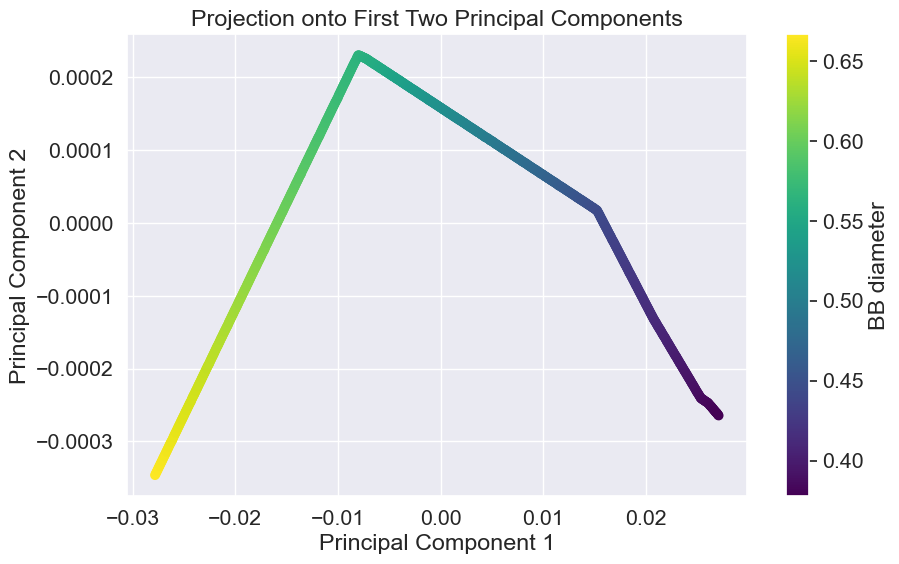

Top 10 features contributing to the first principal component:
Index([91, 16, 25, 124, 46, 113, 78, 79, 85, 70], dtype='int64')
Head tube diameter


C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7328128286966452' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.732292308165385' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.731771787634125' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\App

32/32 [==============================] - 0s 3ms/step


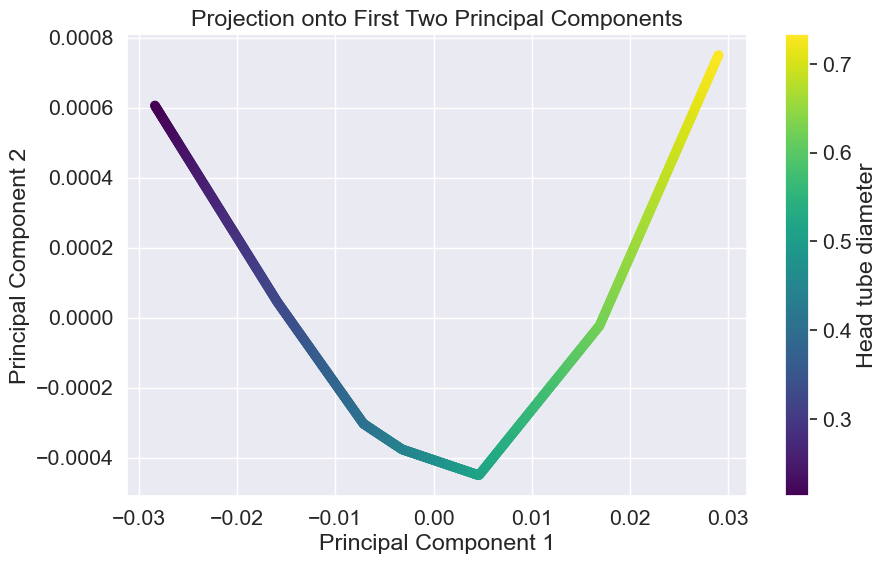

Top 10 features contributing to the first principal component:
Index([1, 16, 113, 124, 78, 46, 79, 91, 25, 105], dtype='int64')
Wheel width rear


C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.491731893118318' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.49133779823004425' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.49094370334177045' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\

32/32 [==============================] - 0s 2ms/step


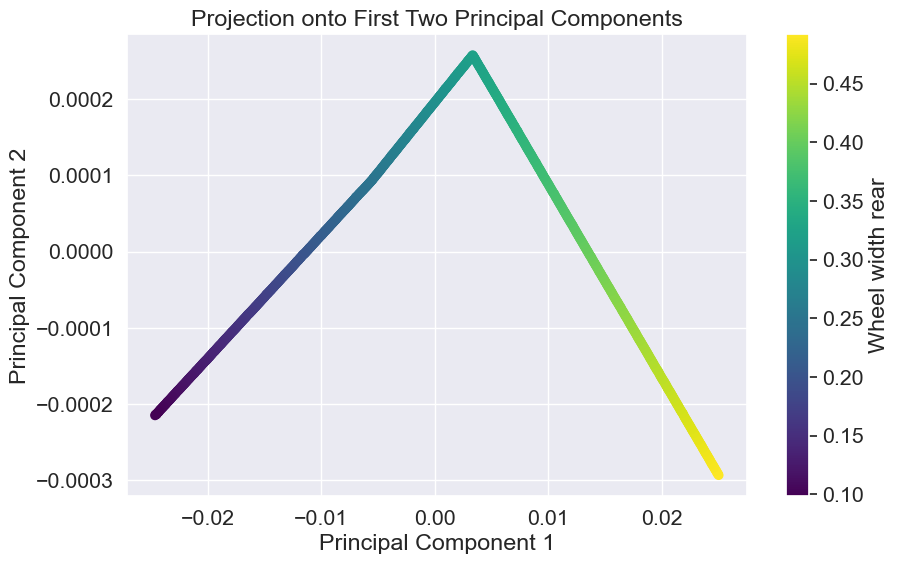

Top 10 features contributing to the first principal component:
Index([113, 16, 91, 79, 1, 124, 78, 25, 46, 9], dtype='int64')
CHAINSTAYbrdgdia1


C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.298161313996778' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2980770191869459' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.29799272437711377' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\A

32/32 [==============================] - 0s 2ms/step


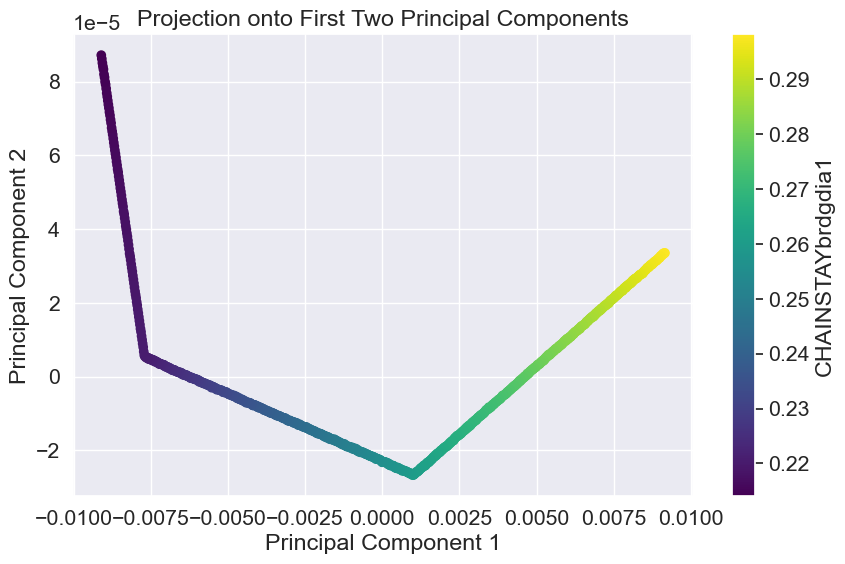

Top 10 features contributing to the first principal component:
Index([113, 16, 46, 25, 91, 79, 78, 1, 69, 111], dtype='int64')
Saddle length


C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.24272844315440328' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.24259974302591625' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.24247104289742918' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabi

32/32 [==============================] - 0s 4ms/step


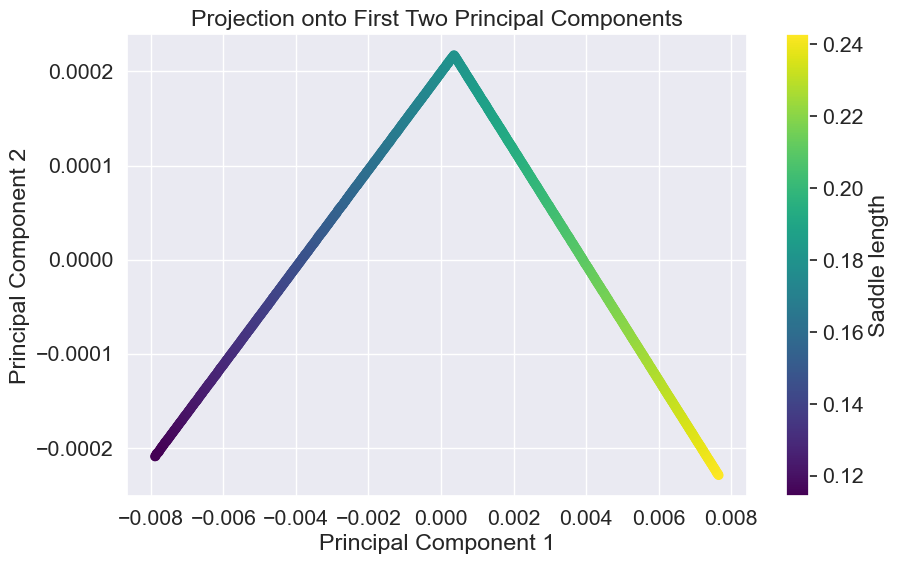

Top 10 features contributing to the first principal component:
Index([91, 124, 16, 1, 79, 46, 78, 113, 25, 65], dtype='int64')
Seat angle


C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6520520753569312' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6519302143468274' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6518083533367237' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\A

32/32 [==============================] - 0s 2ms/step


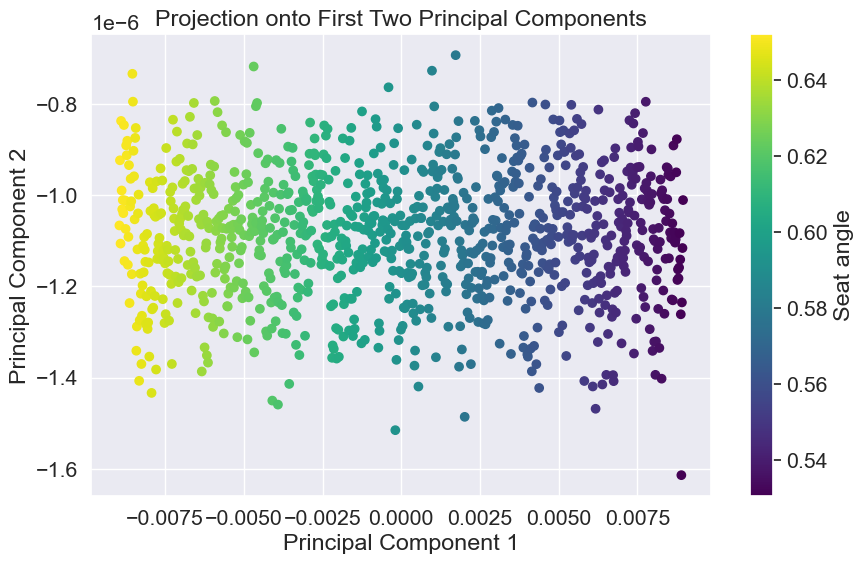

Top 10 features contributing to the first principal component:
Index([78, 25, 113, 124, 1, 46, 91, 16, 79, 125], dtype='int64')
Head tube length textfield


C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1580702291542405' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1579635146486986' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.15785680014315667' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\

32/32 [==============================] - 0s 3ms/step


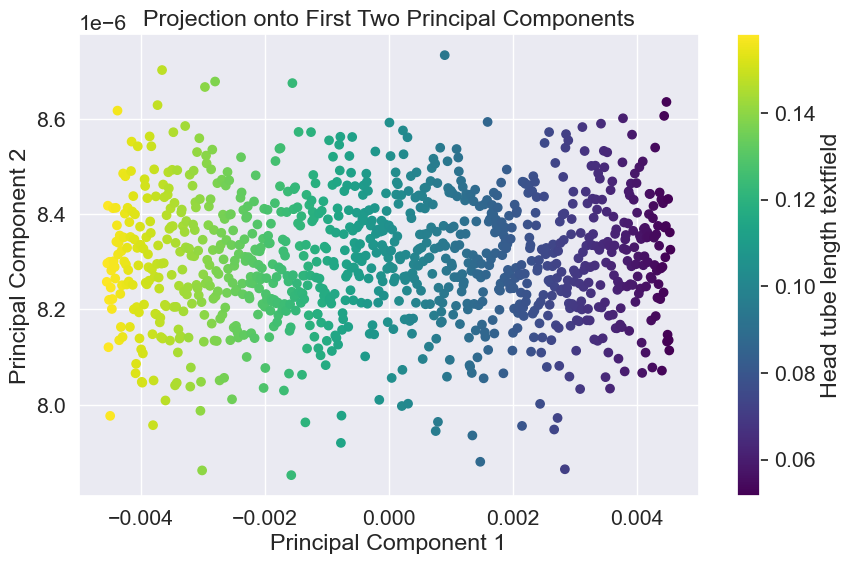

Top 10 features contributing to the first principal component:
Index([91, 79, 16, 1, 113, 25, 83, 0, 46, 78], dtype='int64')
BB length


C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.023996170891730395' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.023981042769369302' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.023965914647008205' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\f

32/32 [==============================] - 0s 4ms/step


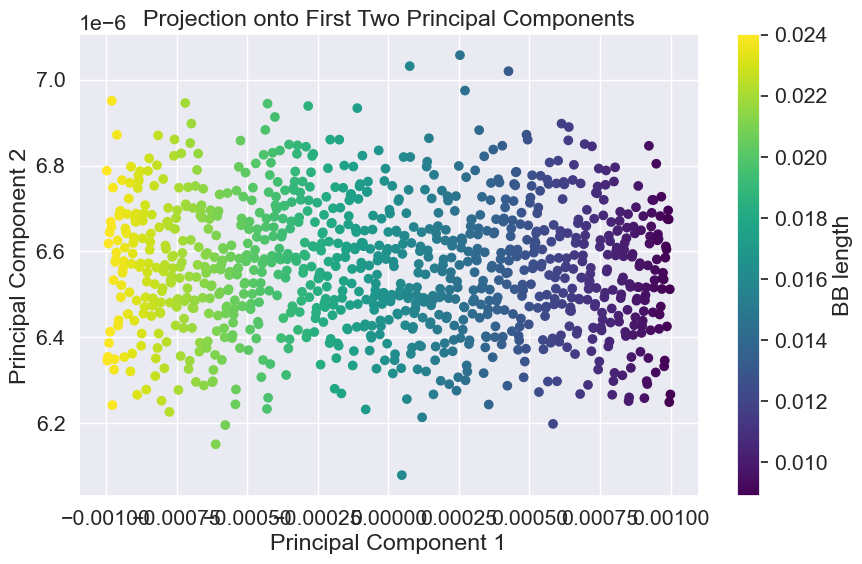

Top 10 features contributing to the first principal component:
Index([46, 25, 79, 78, 113, 124, 91, 1, 121, 89], dtype='int64')
SBLADEW rear


C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5552589891252814' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.554962396204054' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5546658032828266' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\Ap

32/32 [==============================] - 0s 2ms/step


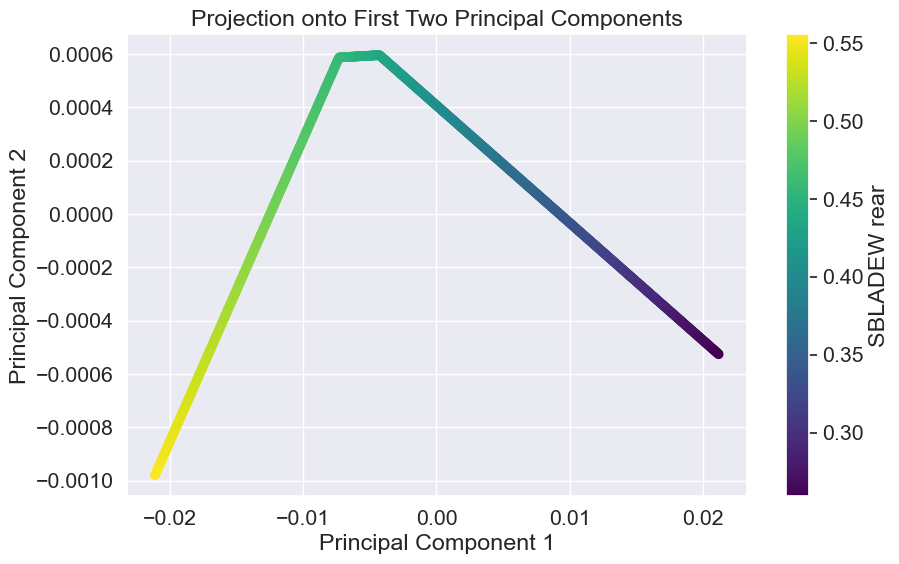

Top 10 features contributing to the first principal component:
Index([16, 25, 124, 46, 91, 113, 1, 79, 78, 90], dtype='int64')
Wheel width front


C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.491731893118318' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.49133779823004425' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.49094370334177045' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\

32/32 [==============================] - 0s 5ms/step


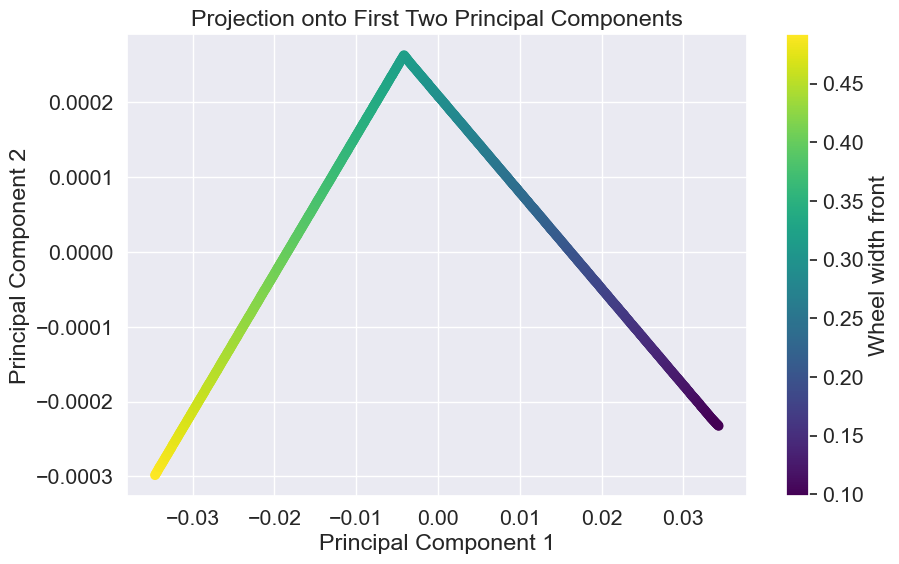

Top 10 features contributing to the first principal component:
Index([124, 113, 78, 79, 16, 1, 91, 25, 46, 9], dtype='int64')
Wheel cut


C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8312350191153564' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8311161354139402' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8309972517125241' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\A

32/32 [==============================] - 0s 2ms/step


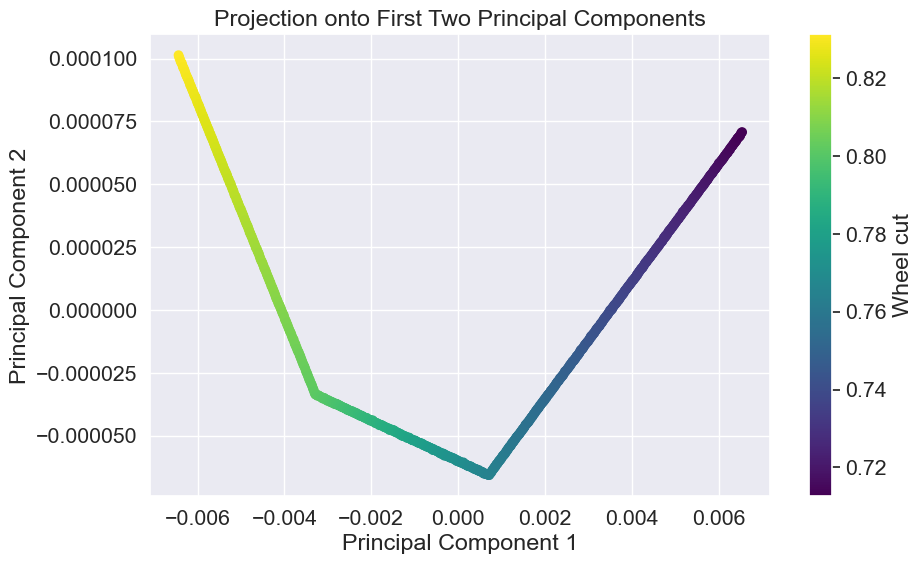

Top 10 features contributing to the first principal component:
Index([46, 25, 16, 79, 124, 1, 113, 78, 100, 3], dtype='int64')
Wall thickness Seat tube
32/32 [==============================] - 0s 5ms/step


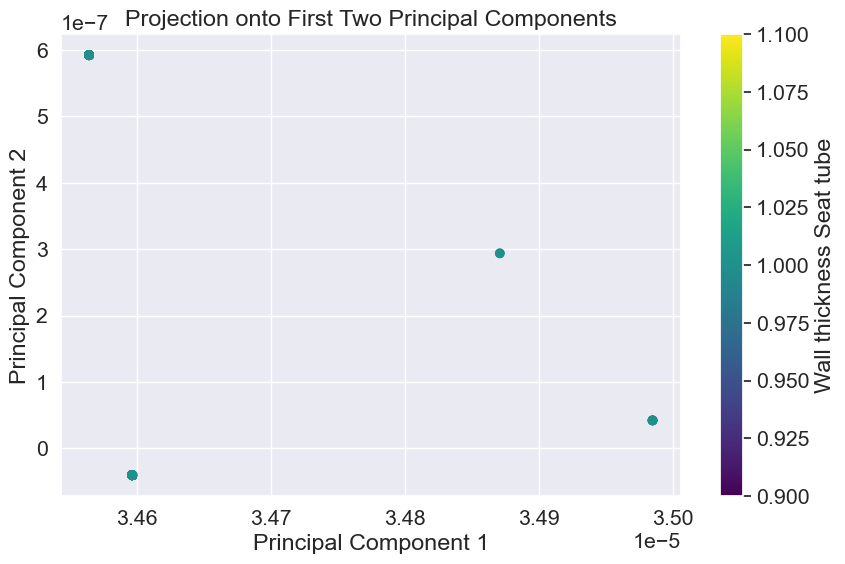

Top 10 features contributing to the first principal component:
Index([91, 16, 25, 124, 113, 79, 78, 85, 37, 96], dtype='int64')
Number of cogs


C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.998998998998999' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.997997997997998' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppData\Local\Temp\ipykernel_26532\866293947.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.996996996996997' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  sample[column] = htl
C:\Users\fabie\AppD

32/32 [==============================] - 0s 3ms/step


In [47]:
# column = 'Head tube lower extension2'
for column in intersection:
    print(column)
    bike_max_htl = edited_df.loc[edited_df[column].idxmax()]
    # mid_bike = edited_df.loc[1385 ]
    head_tube_lengths = np.linspace(bike_max_htl[column], edited_df[column].min(), 1000)

    # Create new samples
    new_samples = []

    for htl in head_tube_lengths:
        # sample = edited_df.loc[1034 ].copy()
        sample = bike_max_htl.copy()
        sample[column] = htl
        new_samples.append(sample)

    # Create a new DataFrame with these samples
    new_df = pd.DataFrame(new_samples)

    # Encode the new DataFrame to obtain the latent representation
    latent_fixed = encoder_mean.predict(new_df)
    latent_fixed_df = pd.DataFrame(latent_fixed, index=new_df.index)

    # Identify and exclude constant latent variables
    non_constant_columns = latent_fixed_df.loc[:, (latent_fixed_df != latent_fixed_df.iloc[0]).any()].columns
    latent_fixed_df = latent_fixed_df[non_constant_columns]

    # Compute the correlation matrix for the non-constant latent variables
    correlation_matrix = latent_fixed_df.corr()

    # sns.set(font_scale=1.4)
    # plt.figure(figsize=(20, 16))
    # sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
    # # plt.title('Correlation Matrix')
    # plt.show()


    # Assuming latent_fixed_df is already defined

    # Perform PCA on the latent representation
    pca = PCA()
    pca.fit(latent_fixed_df)

    # Get the explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    # # Plot the explained variance to determine how many components to consider
    # plt.figure(figsize=(10, 6))
    # plt.plot(np.cumsum(explained_variance_ratio), marker='o')
    # plt.xlabel('Number of Components')
    # plt.ylabel('Cumulative Explained Variance')
    # plt.title('Explained Variance by Principal Components')
    # plt.grid(True)
    # plt.show()

    # Choose the number of components that explain a significant amount of variance (e.g., 95%)
    n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.95) + 1

    # Ensure that n_components is at least 2 for visualization purposes
    n_components = max(n_components, 2)

    # Perform PCA again with the chosen number of components
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(latent_fixed_df)

    # Create a DataFrame with the principal components
    principal_components_df = pd.DataFrame(principal_components, index=new_df.index)

    # Check the shape of the DataFrame to ensure it has at least two components
    if principal_components_df.shape[1] >= 2:
        # Visualize the data in the space of the first two principal components
        plt.figure(figsize=(10, 6))
        plt.scatter(principal_components_df.iloc[:, 0], principal_components_df.iloc[:, 1], c=head_tube_lengths, cmap='viridis')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.colorbar(label=column)
        plt.title('Projection onto First Two Principal Components')
        plt.grid(True)
        plt.show()
    else:
        print("PCA did not produce at least two components.")

    # Analyze the principal components to understand the directions of variation
    loading_scores = pd.Series(pca.components_[0], index=latent_fixed_df.columns)
    sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
    top_features = sorted_loading_scores.index[:10]

    print("Top 10 features contributing to the first principal component:")
    print(top_features)